In [1]:
import os
import cv2
import numpy as np
import scipy.io as sio
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [2]:
images_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\test_data\images"
gt_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\test_data\ground-truth"
# out_img_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed\images"
# out_den_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed\density"

In [6]:
os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_den_dir, exist_ok=True)

In [10]:
def generate_density_map(img, points, k=3):
    density = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)

    for pt in points:
        x = min(img.shape[1] - 1, max(0, int(pt[0])))
        y = min(img.shape[0] - 1, max(0, int(pt[1])))
        density[y, x] += 1

    density = gaussian_filter(density, sigma=k)
    return density

In [12]:
image_list = sorted(os.listdir(images_dir))
print("Total images:", len(image_list))

for img_name in tqdm(image_list):
    if not img_name.endswith(".jpg"):
        continue

    img_path = os.path.join(images_dir, img_name)

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # GT .mat file
    mat_name = "GT_" + img_name.replace(".jpg", ".mat")
    gt_path = os.path.join(gt_dir, mat_name)

    # -----------------------------------------
    # READ .MAT → GET POINTS
    # -----------------------------------------
    mat = sio.loadmat(gt_path)
    points = mat["image_info"][0][0][0][0][0]   # EXACT STRUCTURE FOR SHANGHAITECH

    # -----------------------------------------
    # Generate Density Map
    # -----------------------------------------
    density = generate_density_map(img, points, k=3)

    # SAVE image + density
    cv2.imwrite(os.path.join(out_img_dir, img_name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    np.save(os.path.join(out_den_dir, img_name.replace(".jpg", ".npy")), density)


Total images: 300


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:10<00:00, 29.73it/s]


Density Count: 1546.0


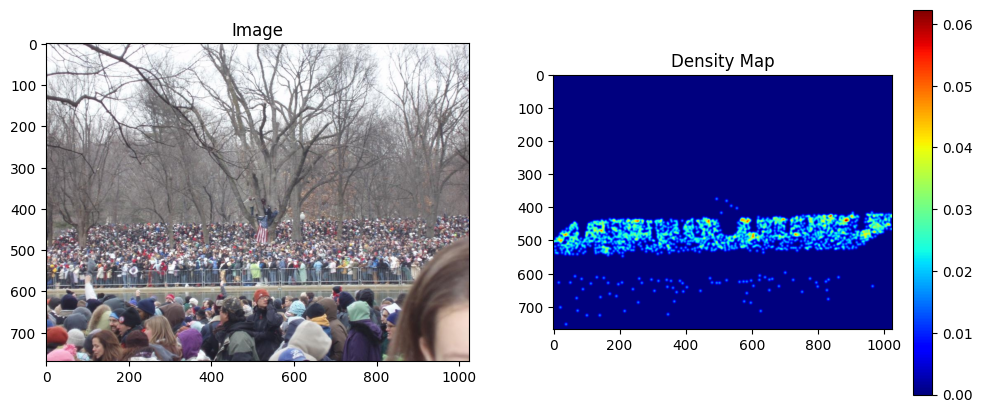

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

img_path = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed\images\IMG_1.jpg"
den_path = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\train_data\processed\density\IMG_1.npy"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

density = np.load(den_path)
print("Density Count:", density.sum())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("Density Map")
plt.imshow(density, cmap="jet")
plt.colorbar()
plt.show()


In [3]:
def load_points_from_mat(mat_path):
    """
    ShanghaiTech format: image_info -> location -> Nx2 array (x,y)
    """
    data = sio.loadmat(mat_path)
    pts = data["image_info"][0][0][0][0][0]
    return pts  # shape (N,2)


def create_density(img, points, sigma=15):
    H, W = img.shape[:2]
    den = np.zeros((H, W), dtype=np.float32)

    for x, y in points:
        x = min(int(x), W - 1)
        y = min(int(y), H - 1)
        den[y, x] += 1

    den = gaussian_filter(den, sigma=sigma)
    return den


def preprocess_image(img_path, mat_path, out_img_dir, out_den_dir, down=8):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    # Load points from .mat
    pts = load_points_from_mat(mat_path)

    # Create density map
    den = create_density(img, pts, sigma=15)

    # Downsample for CSRNet
    den_ds = cv2.resize(den, (W // down, H // down), interpolation=cv2.INTER_CUBIC)
    den_ds = den_ds * (down * down)

    # Check count drift
    drift = abs(den_ds.sum() - len(pts))
    if drift > 0.01 * len(pts):
        print(f"[WARNING] Count drift = {drift:.2f} in {os.path.basename(img_path)}")

    # Save outputs
    base = os.path.basename(img_path).replace(".jpg", "")
    cv2.imwrite(os.path.join(out_img_dir, base + ".jpg"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    np.save(os.path.join(out_den_dir, base + ".npy"), den_ds)

    print(f"[OK] {base}: GT={len(pts)}, DS={den_ds.sum():.2f}")

In [4]:
out_img_dir = "processed_test_A/images"
out_den_dir = "processed_test_A/density"

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_den_dir, exist_ok=True)

files = sorted(os.listdir(images_dir))

for file in files:
    if not file.endswith(".jpg"):
      continue

    img_path = os.path.join(images_dir, file)
    mat_path = os.path.join(gt_dir, "GT_" + file.replace(".jpg", ".mat"))

    if not os.path.exists(mat_path):
        print("Missing GT for:", file)
        continue

    preprocess_image(img_path, mat_path, out_img_dir, out_den_dir)

print("\n✔ COMPLETED — All .mat files processed!")

[OK] IMG_1: GT=172, DS=172.00
[OK] IMG_10: GT=502, DS=502.00
[OK] IMG_100: GT=389, DS=385.50
[OK] IMG_101: GT=211, DS=210.59
[WARNING] Count drift = 5.14 in IMG_102.jpg
[OK] IMG_102: GT=223, DS=217.86
[OK] IMG_103: GT=431, DS=429.52
[OK] IMG_104: GT=1175, DS=1169.85
[OK] IMG_105: GT=265, DS=263.00
[OK] IMG_106: GT=1232, DS=1220.44
[WARNING] Count drift = 5.76 in IMG_107.jpg
[OK] IMG_107: GT=289, DS=283.24
[OK] IMG_108: GT=182, DS=182.00
[OK] IMG_109: GT=379, DS=377.37
[OK] IMG_11: GT=1068, DS=1063.32
[OK] IMG_110: GT=1021, DS=1015.62
[OK] IMG_111: GT=452, DS=449.88
[OK] IMG_112: GT=256, DS=256.00
[OK] IMG_113: GT=66, DS=65.77
[OK] IMG_114: GT=141, DS=141.00
[OK] IMG_115: GT=1191, DS=1185.16
[WARNING] Count drift = 3.87 in IMG_116.jpg
[OK] IMG_116: GT=288, DS=284.13
[OK] IMG_117: GT=1603, DS=1595.87
[OK] IMG_118: GT=241, DS=239.56
[OK] IMG_119: GT=250, DS=248.52
[OK] IMG_12: GT=321, DS=321.00
[WARNING] Count drift = 1.62 in IMG_120.jpg
[OK] IMG_120: GT=133, DS=131.38
[OK] IMG_121: GT=12

In [6]:
import cv2
import numpy as np

img = cv2.imread("processed_test_A/images/IMG_1.jpg")
den = np.load("processed_test_A/density/IMG_1.npy")

print("Image shape:", img.shape)
print("Density shape:", den.shape)
print("Density sum:", den.sum())



Image shape: (704, 1024, 3)
Density shape: (88, 128)
Density sum: 172.00017


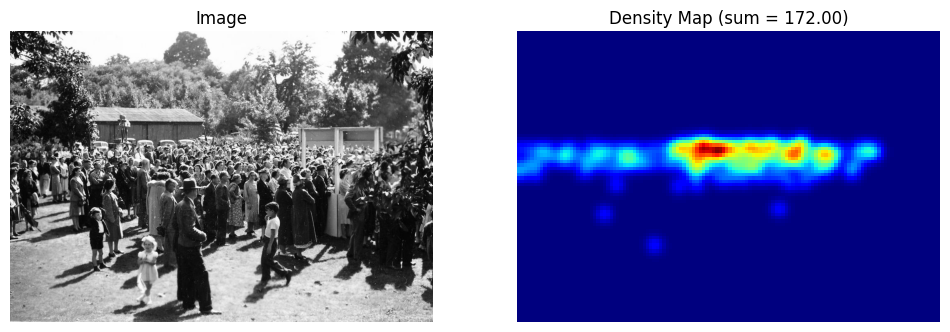

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("processed_test_A/images/IMG_1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
den = np.load("processed_test_A/density/IMG_1.npy")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"Density Map (sum = {den.sum():.2f})")
plt.imshow(den, cmap='jet')
plt.axis("off")

plt.show()


In [8]:
import os
import numpy as np

den_dir = "processed_test_A/density"
files = sorted(os.listdir(den_dir))[:5]

for f in files:
    d = np.load(os.path.join(den_dir, f))
    print(f"{f}: shape={d.shape}, sum={d.sum():.2f}")


IMG_1.npy: shape=(88, 128), sum=172.00
IMG_10.npy: shape=(96, 128), sum=502.00
IMG_100.npy: shape=(51, 112), sum=385.50
IMG_101.npy: shape=(96, 120), sum=210.59
IMG_102.npy: shape=(34, 57), sum=217.86


In [19]:
import os
import cv2
import time
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models 
import torch.nn.functional as F


In [20]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, transform=None):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        den_path = os.path.join(self.den_dir, img_name.replace(".jpg", ".npy"))

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Load density map
        den = np.load(den_path)
        den = torch.from_numpy(den).unsqueeze(0).float()

        if self.transform:
            img = self.transform(img)

        return img, den


In [21]:
train_transform = transforms.Compose([
    transforms.Resize((768, 1024)),
    transforms.ToTensor(),
])

img_dir = "processed/images"
den_dir = "processed/density"

dataset = CrowdDataset(img_dir, den_dir, transform=train_transform)

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [22]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        # VGG16 frontend WITHOUT pretrained weights
        self.frontend = nn.Sequential(
            *list(models.vgg16(weights=None).features)[:23]
        )

        # Backend
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(),
        )

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return F.relu(x)


In [23]:
device = torch.device("cpu")

model = CSRNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [24]:
num_epochs = 10
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0

    pbar = tqdm(train_loader, total=len(train_loader))
    for imgs, dens in pbar:
        imgs = imgs.to(device)
        dens = dens.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # Resize outputs to match ground-truth density map
        if outputs.shape != dens.shape:
            outputs = F.interpolate(outputs, size=dens.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, dens)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch} Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"\n--- Epoch {epoch}/{num_epochs} | Avg Loss = {avg_loss:.4f} ---")

    # Save checkpoint
    ckpt_path = os.path.join(checkpoint_dir, f"csrnet_epoch{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, ckpt_path)

    print(f"Checkpoint saved: {ckpt_path}")

Epoch 1 Loss: 0.0008:   3%|▎         | 9/300 [02:38<1:25:25, 17.61s/it]


KeyboardInterrupt: 

In [25]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os

num_epochs = 10
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_gt_count = 0.0
    running_pred_count = 0.0
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

    for i, (imgs, density_maps) in enumerate(tqdm(train_loader, desc="Training batches")):
        imgs = imgs.to(device)
        density_maps = density_maps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = F.relu(outputs)  # ensure predictions >= 0

        # Resize density maps if necessary
        if outputs.shape != density_maps.shape:
            density_maps_resized = F.interpolate(density_maps, size=outputs.shape[2:], mode='nearest')
        else:
            density_maps_resized = density_maps

        loss = criterion(outputs, density_maps_resized)
        loss.backward()
        optimizer.step()

        # Metrics
        batch_gt_count = density_maps_resized.sum().item()
        batch_pred_count = outputs.sum().item()
        running_loss += loss.item()
        running_gt_count += batch_gt_count
        running_pred_count += batch_pred_count

        # Print batch metrics every 10 batches or at last batch
        if (i+1) % 10 == 0 or i == len(train_loader)-1:
            print(f"Batch {i+1}/{len(train_loader)}, "
                  f"Loss: {loss.item():.6f}, "
                  f"GT Count: {batch_gt_count:.2f}, "
                  f"Pred Count: {batch_pred_count:.2f}")

    # Epoch metrics
    avg_loss = running_loss / len(train_loader)
    avg_gt_count = running_gt_count / len(train_loader)
    avg_pred_count = running_pred_count / len(train_loader)
    print(f"\n--- Epoch {epoch+1} Summary ---")
    print(f"Average Loss: {avg_loss:.6f}")
    print(f"Average GT Count: {avg_gt_count:.2f}")
    print(f"Average Pred Count: {avg_pred_count:.2f}")

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"csrnet_epoch{epoch+1}.pth")
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at: {checkpoint_path}")



=== Epoch 1/10 ===


Training batches:   3%|▎         | 10/300 [02:17<1:06:36, 13.78s/it]

Batch 10/300, Loss: 0.005294, GT Count: 522.64, Pred Count: 0.00


Training batches:   7%|▋         | 20/300 [04:58<1:12:52, 15.61s/it]

Batch 20/300, Loss: 0.042871, GT Count: 1873.22, Pred Count: 0.00


Training batches:  10%|█         | 30/300 [07:18<1:03:34, 14.13s/it]

Batch 30/300, Loss: 0.024051, GT Count: 1307.43, Pred Count: 0.00


Training batches:  13%|█▎        | 40/300 [09:50<1:08:00, 15.69s/it]

Batch 40/300, Loss: 0.001045, GT Count: 115.00, Pred Count: 0.00


Training batches:  17%|█▋        | 50/300 [12:14<1:00:00, 14.40s/it]

Batch 50/300, Loss: 0.097515, GT Count: 3651.69, Pred Count: 0.00


Training batches:  20%|██        | 60/300 [14:53<1:05:10, 16.29s/it]

Batch 60/300, Loss: 0.004048, GT Count: 402.68, Pred Count: 0.00


Training batches:  23%|██▎       | 70/300 [17:32<56:54, 14.85s/it]  

Batch 70/300, Loss: 0.004358, GT Count: 723.00, Pred Count: 0.00


Training batches:  27%|██▋       | 80/300 [19:56<52:39, 14.36s/it]

Batch 80/300, Loss: 0.067035, GT Count: 2760.48, Pred Count: 0.00


Training batches:  30%|███       | 90/300 [22:38<56:47, 16.23s/it]

Batch 90/300, Loss: 0.001933, GT Count: 120.67, Pred Count: 0.00


Training batches:  33%|███▎      | 100/300 [25:21<54:10, 16.25s/it]

Batch 100/300, Loss: 0.033873, GT Count: 1146.51, Pred Count: 0.00


Training batches:  37%|███▋      | 110/300 [28:04<51:34, 16.28s/it]

Batch 110/300, Loss: 0.023581, GT Count: 775.60, Pred Count: 0.00


Training batches:  40%|████      | 120/300 [30:47<48:52, 16.29s/it]

Batch 120/300, Loss: 0.040150, GT Count: 1812.60, Pred Count: 0.00


Training batches:  43%|████▎     | 130/300 [33:31<46:13, 16.32s/it]

Batch 130/300, Loss: 0.018158, GT Count: 1141.61, Pred Count: 0.00


Training batches:  47%|████▋     | 140/300 [36:13<43:22, 16.27s/it]

Batch 140/300, Loss: 0.000934, GT Count: 223.21, Pred Count: 0.00


Training batches:  50%|█████     | 150/300 [38:57<40:35, 16.24s/it]

Batch 150/300, Loss: 0.002129, GT Count: 212.00, Pred Count: 0.00


Training batches:  53%|█████▎    | 160/300 [41:40<38:10, 16.36s/it]

Batch 160/300, Loss: 0.000785, GT Count: 228.39, Pred Count: 0.00


Training batches:  57%|█████▋    | 170/300 [44:22<35:11, 16.24s/it]

Batch 170/300, Loss: 0.001125, GT Count: 159.77, Pred Count: 0.00


Training batches:  60%|██████    | 180/300 [47:04<32:27, 16.23s/it]

Batch 180/300, Loss: 0.002213, GT Count: 348.69, Pred Count: 0.00


Training batches:  63%|██████▎   | 190/300 [49:51<30:34, 16.67s/it]

Batch 190/300, Loss: 0.013802, GT Count: 1167.03, Pred Count: 0.00


Training batches:  67%|██████▋   | 200/300 [52:34<27:14, 16.35s/it]

Batch 200/300, Loss: 0.021614, GT Count: 1294.30, Pred Count: 0.00


Training batches:  70%|███████   | 210/300 [55:17<24:46, 16.52s/it]

Batch 210/300, Loss: 0.004501, GT Count: 727.56, Pred Count: 0.00


Training batches:  73%|███████▎  | 220/300 [58:00<21:37, 16.22s/it]

Batch 220/300, Loss: 0.073241, GT Count: 1631.62, Pred Count: 0.00


Training batches:  77%|███████▋  | 230/300 [1:00:43<19:04, 16.36s/it]

Batch 230/300, Loss: 0.002787, GT Count: 374.02, Pred Count: 0.00


Training batches:  80%|████████  | 240/300 [1:03:28<16:18, 16.31s/it]

Batch 240/300, Loss: 0.009773, GT Count: 313.09, Pred Count: 0.00


Training batches:  83%|████████▎ | 250/300 [1:06:11<13:33, 16.28s/it]

Batch 250/300, Loss: 0.007023, GT Count: 659.22, Pred Count: 0.00


Training batches:  87%|████████▋ | 260/300 [1:08:53<10:47, 16.19s/it]

Batch 260/300, Loss: 0.004742, GT Count: 418.89, Pred Count: 0.00


Training batches:  90%|█████████ | 270/300 [1:11:40<08:14, 16.49s/it]

Batch 270/300, Loss: 0.011115, GT Count: 759.87, Pred Count: 0.00


Training batches:  93%|█████████▎| 280/300 [1:14:22<05:23, 16.19s/it]

Batch 280/300, Loss: 0.137170, GT Count: 3391.14, Pred Count: 0.00


Training batches:  97%|█████████▋| 290/300 [2:14:26<2:54:44, 1048.41s/it]

Batch 290/300, Loss: 0.005746, GT Count: 291.86, Pred Count: 0.00


Training batches: 100%|██████████| 300/300 [2:17:05<00:00, 27.42s/it]    

Batch 300/300, Loss: 0.000520, GT Count: 172.41, Pred Count: 0.00

--- Epoch 1 Summary ---
Average Loss: 0.025982
Average GT Count: 928.34
Average Pred Count: 0.00


Checkpoint saved at: checkpoints\csrnet_epoch1.pth

=== Epoch 2/10 ===


Training batches:   3%|▎         | 10/300 [02:22<1:15:41, 15.66s/it]

Batch 10/300, Loss: 0.002947, GT Count: 288.01, Pred Count: 0.00


Training batches:   7%|▋         | 20/300 [05:23<1:42:05, 21.88s/it]

Batch 20/300, Loss: 0.001152, GT Count: 260.76, Pred Count: 0.00


Training batches:  10%|█         | 30/300 [08:23<1:24:44, 18.83s/it]

Batch 30/300, Loss: 0.004412, GT Count: 716.96, Pred Count: 0.00


Training batches:  13%|█▎        | 40/300 [11:31<1:21:11, 18.73s/it]

Batch 40/300, Loss: 0.007660, GT Count: 755.96, Pred Count: 0.00


Training batches:  17%|█▋        | 50/300 [15:02<1:27:32, 21.01s/it]

Batch 50/300, Loss: 0.011508, GT Count: 752.00, Pred Count: 0.00


Training batches:  20%|██        | 60/300 [18:37<1:25:20, 21.33s/it]

Batch 60/300, Loss: 0.042871, GT Count: 1873.22, Pred Count: 0.00


Training batches:  23%|██▎       | 70/300 [22:04<1:24:27, 22.03s/it]

Batch 70/300, Loss: 0.010844, GT Count: 777.00, Pred Count: 0.00


Training batches:  27%|██▋       | 80/300 [29:11<2:36:21, 42.64s/it]

Batch 80/300, Loss: 0.014872, GT Count: 908.34, Pred Count: 0.00


Training batches:  30%|███       | 90/300 [35:24<2:12:20, 37.81s/it]

Batch 90/300, Loss: 0.000532, GT Count: 186.89, Pred Count: 0.00


Training batches:  33%|███▎      | 100/300 [41:55<2:12:04, 39.62s/it]

Batch 100/300, Loss: 0.217793, GT Count: 2261.00, Pred Count: 0.00


Training batches:  37%|███▋      | 110/300 [48:35<2:05:09, 39.52s/it]

Batch 110/300, Loss: 0.002945, GT Count: 275.93, Pred Count: 0.00


Training batches:  40%|████      | 120/300 [56:07<2:24:19, 48.11s/it]

Batch 120/300, Loss: 0.004095, GT Count: 393.62, Pred Count: 0.00


Training batches:  43%|████▎     | 130/300 [1:02:54<1:52:35, 39.74s/it]

Batch 130/300, Loss: 0.005003, GT Count: 388.00, Pred Count: 0.00


Training batches:  47%|████▋     | 140/300 [1:09:08<1:38:02, 36.77s/it]

Batch 140/300, Loss: 0.023195, GT Count: 852.41, Pred Count: 0.00


Training batches:  50%|█████     | 150/300 [1:15:16<1:33:26, 37.38s/it]

Batch 150/300, Loss: 0.011443, GT Count: 1007.32, Pred Count: 0.00


Training batches:  53%|█████▎    | 160/300 [1:22:37<1:29:39, 38.42s/it]

Batch 160/300, Loss: 0.004742, GT Count: 418.89, Pred Count: 0.00


Training batches:  57%|█████▋    | 170/300 [1:29:11<1:24:49, 39.15s/it]

Batch 170/300, Loss: 0.176634, GT Count: 2114.26, Pred Count: 0.00


Training batches:  60%|██████    | 180/300 [1:35:20<1:14:33, 37.28s/it]

Batch 180/300, Loss: 0.007362, GT Count: 498.32, Pred Count: 0.00


Training batches:  63%|██████▎   | 190/300 [1:41:58<1:12:36, 39.61s/it]

Batch 190/300, Loss: 0.004606, GT Count: 736.99, Pred Count: 0.00


Training batches:  67%|██████▋   | 200/300 [1:48:12<1:03:29, 38.10s/it]

Batch 200/300, Loss: 0.002464, GT Count: 458.20, Pred Count: 0.00


Training batches:  70%|███████   | 210/300 [1:54:19<53:30, 35.68s/it]  

Batch 210/300, Loss: 0.165629, GT Count: 4367.90, Pred Count: 0.00


Training batches:  73%|███████▎  | 220/300 [2:00:22<47:46, 35.83s/it]

Batch 220/300, Loss: 0.003750, GT Count: 325.02, Pred Count: 0.00


Training batches:  77%|███████▋  | 230/300 [2:04:46<25:06, 21.52s/it]

Batch 230/300, Loss: 0.201013, GT Count: 4638.85, Pred Count: 0.00


Training batches:  80%|████████  | 240/300 [2:08:19<21:24, 21.41s/it]

Batch 240/300, Loss: 0.000952, GT Count: 145.28, Pred Count: 0.00


Training batches:  83%|████████▎ | 250/300 [2:11:30<15:57, 19.14s/it]

Batch 250/300, Loss: 0.006063, GT Count: 361.82, Pred Count: 0.00


Training batches:  87%|████████▋ | 260/300 [2:14:36<12:45, 19.13s/it]

Batch 260/300, Loss: 0.003984, GT Count: 526.37, Pred Count: 0.00


Training batches:  90%|█████████ | 270/300 [2:17:47<09:36, 19.22s/it]

Batch 270/300, Loss: 0.001355, GT Count: 241.00, Pred Count: 0.00


Training batches:  93%|█████████▎| 280/300 [2:21:06<06:36, 19.83s/it]

Batch 280/300, Loss: 0.003933, GT Count: 357.00, Pred Count: 0.00


Training batches:  97%|█████████▋| 290/300 [2:24:22<03:14, 19.45s/it]

Batch 290/300, Loss: 0.010772, GT Count: 462.00, Pred Count: 0.00


Training batches: 100%|██████████| 300/300 [2:27:35<00:00, 29.52s/it]

Batch 300/300, Loss: 0.000957, GT Count: 268.85, Pred Count: 0.00

--- Epoch 2 Summary ---
Average Loss: 0.025982
Average GT Count: 928.34
Average Pred Count: 0.00


Checkpoint saved at: checkpoints\csrnet_epoch2.pth

=== Epoch 3/10 ===


Training batches:   3%|▎         | 10/300 [03:11<1:33:03, 19.25s/it]

Batch 10/300, Loss: 0.001045, GT Count: 115.00, Pred Count: 0.00


Training batches:   7%|▋         | 20/300 [06:21<1:28:09, 18.89s/it]

Batch 20/300, Loss: 0.012982, GT Count: 824.41, Pred Count: 0.00


Training batches:  10%|█         | 30/300 [09:34<1:26:31, 19.23s/it]

Batch 30/300, Loss: 0.066518, GT Count: 2042.24, Pred Count: 0.00


Training batches:  13%|█▎        | 40/300 [12:58<1:25:02, 19.63s/it]

Batch 40/300, Loss: 0.051638, GT Count: 1019.42, Pred Count: 0.00


Training batches:  17%|█▋        | 50/300 [16:09<1:19:43, 19.14s/it]

Batch 50/300, Loss: 0.019441, GT Count: 662.35, Pred Count: 0.00


Training batches:  20%|██        | 60/300 [19:41<1:23:55, 20.98s/it]

Batch 60/300, Loss: 0.000509, GT Count: 211.96, Pred Count: 0.00


Training batches:  23%|██▎       | 70/300 [23:07<1:15:53, 19.80s/it]

Batch 70/300, Loss: 0.000760, GT Count: 250.03, Pred Count: 0.00


Training batches:  27%|██▋       | 80/300 [26:17<1:10:31, 19.23s/it]

Batch 80/300, Loss: 0.011334, GT Count: 765.51, Pred Count: 0.00


Training batches:  30%|███       | 90/300 [29:23<1:05:09, 18.62s/it]

Batch 90/300, Loss: 0.029818, GT Count: 1332.36, Pred Count: 0.00


Training batches:  33%|███▎      | 100/300 [32:40<1:04:01, 19.21s/it]

Batch 100/300, Loss: 0.005038, GT Count: 598.71, Pred Count: 0.00


Training batches:  37%|███▋      | 110/300 [35:55<1:02:44, 19.81s/it]

Batch 110/300, Loss: 0.007621, GT Count: 760.34, Pred Count: 0.00


Training batches:  40%|████      | 120/300 [39:28<1:03:11, 21.06s/it]

Batch 120/300, Loss: 0.006277, GT Count: 470.88, Pred Count: 0.00


Training batches:  43%|████▎     | 130/300 [42:56<55:55, 19.74s/it]  

Batch 130/300, Loss: 0.005271, GT Count: 396.15, Pred Count: 0.00


Training batches:  44%|████▎     | 131/300 [43:34<56:12, 19.96s/it]


KeyboardInterrupt: 

In [ ]:
def predict_count(model, img_path):
    model.eval()

    img = Image.open(img_path).convert("RGB")
    img = train_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        den = model(img).cpu().numpy()[0][0]

    return den.sum(), den

test_img = "processed/images/IMG_1.jpg"
count, den_map = predict_count(model, test_img)

print("Predicted Count:", count)
